# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [9]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider the **standard OLG-model** where:

We assume that utility is given by $u(c)$ with constant relative risk aversion (CRRA utility function): 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

Individuals live for two periods, t = 1,2. $L_t$ individuals are born in period t and we assume that the population grows with a constant rate, n: 

$$ L_t = L_{t-1}(1+n) $$

agents derive utility while alive: 

$$ U_t = u(c_{1t})+\frac{1}{1+\rho} u(c_{2t}) $$

Agtens' budget constraint in each period is given by: 

$$ c_{1t} + s_t = w_t $$

$$ c_{2t+1} = (1+r_{t+1}) s_t $$

This implies that agents' lifetime budget constraint is given by: 

$$ c_{1t} + \frac{c_{2t+1}}{1+r_{t+1}} = w_t $$



# Analytical solution

## Household problem

Every agtens born at time t maximize utility subject to their lifetime budget constraint.

For now, we assume $\sigma = 1$, which imply that utility is given by $u(c) = log (c)$

First we define all **symbols**:

In [34]:
c_1t = sm.symbols('c_1t')
c_2t = sm.symbols('c_2t+1')
rho = sm.symbols('rho')
u_1 = sm.symbols('u_1')
u_2 = sm.symbols('u_2')
sigma = sm.symbols('sigma')
w = sm.symbols('w_t')
r_t1 = sm.symbols('r_t+1')
lamb = sm.symbols('lambda')
s = sm.symbols('s_t')
k_2t = sm.symbols('k_t+1')
k_1t = sm.symbols('k_t')
alpha = sm.symbols('alpha')
n = sm.symbols('n')
k_star = sm.symbols('k^*')
Y = sm.symbols('Y_t')
K = sm.symbols('K_t')
L_t = sm.symbols('L_t')
r = sm.symbols('r_t')

In [35]:
#Lifetime utility
u_c1 = sm.ln(c_1t)
u_c2 = sm.ln(c_2t)
U = u_c1 + u_c2/(1+rho)
U

log(c_1t) + log(c_2t+1)/(rho + 1)

In [36]:
# Lagrangian
budget_l = c_1t + c_2t/(1+r_t1) - w
L = U - lamb * budget_l
L



-lambda*(c_1t + c_2t+1/(r_t+1 + 1) - w_t) + log(c_1t) + log(c_2t+1)/(rho + 1)

In [37]:
def Lan(x):
    L_1 = sm.diff(L, x)
    L_2 = sm.Eq(L_1,0)
    L_3 = sm.solve(L_2, lamb) [0]
    return L_3

L_c1 = Lan(c_1t)
L_c2 = Lan(c_2t)

Eu = sm.Eq(L_c1, L_c2)
Eu_1 = sm.solve(Eu, c_2t) [0]
Euler = sm.Eq(c_2t, Eu_1)
Euler




Eq(c_2t+1, c_1t*(r_t+1 + 1)/(rho + 1))

In [38]:
budget_1 = w-s 
budget_2 = (1+r_t1)*s

savings_1 = Euler.subs(c_1t,budget_1)

savings_2 = savings_1.subs(c_2t, budget_2)

savings = sm.solve(savings_2,s)[0]

opt_savings = sm.Eq(s,savings)
opt_savings

Eq(s_t, w_t/(rho + 2))

In [39]:
Y = K**alpha*L_t**(1-alpha)
k_t = sm.diff(Y,K)
k_t = sm.simplify(k_t)
k_t

K_t**(alpha - 1)*L_t**(1 - alpha)*alpha

divide by L

In [40]:
rr = sm.Eq(r,alpha*k_1t**(alpha-1))
rr

Eq(r_t, alpha*k_t**(alpha - 1))

In [17]:
# In equilibrium s = K*L = k
# We know that w is the marginal product of labor and given that the production function is a cobb-douglas we can insert w:

capital = sm.Eq(k_2t*(1+n), (((1-alpha)*k_1t**alpha)/(rho+2)))
capital

# In equilibrium k_t+1 = k_t = k^* so: 

capital_eq=sm.Eq(k_star*(1+n), (((1-alpha)*k_star**alpha)/(rho+2)))
Equilibrium = sm.solve(capital_eq,k_star)[0]
Equilibrium

((1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1))

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [79]:
sigma = 1
rho = 0.05
n = 0.02
alpha = 0.33

## Define functions

In [80]:
def u_func(c,sigma):
    if sigma == 1:
        u = np.log(c)
    else:
        u = (c**(1-sigma)-1)/(1-sigma)
    return u

def utility(sigma,rho,w,r,s):
    return u_func(w-s,sigma) + 1/(1+rho)*u_func((1+r)*s,sigma)

def wage(k,alpha):
    return (1-alpha)*k**alpha

def rr(k,alpha):
     return alpha*k**(alpha-1)
     
def capital_2t(s,n):
    return s/(1+n) 

def savings(w,rho):
    return w/(2+rho)

def transition(k,alpha,rho,n):
    w = wage(k,alpha)
    s = savings(w,rho)
    return capital_2t(s,n)

In [88]:
def transition_curve(alpha,rho,n):

    # a. grids
    capital_1 = np.linspace(1e-8,0.3,500)
    capital_2 = np.empty(500)

    #b. solve for each k in grid
    for i,k in enumerate(capital_1):
        
        # i. capital in t+1
        result = transition(k,alpha,rho,n)
        capital_2[i] = result

    return capital_1,capital_2


In [89]:
capital_1,capital_2 = transition_curve(alpha,rho,n)

k_t+1

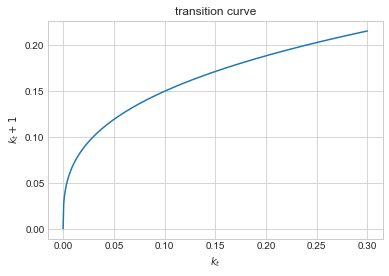

In [90]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(capital_1,capital_2)
ax.set_xlabel('$k_t$')
ax.set_ylabel('$k_t+1$')
ax.set_title('transition curve');

In [96]:
def func(k):
    s = -k + (1/(2+rho)*(1-alpha)*k**alpha*(1+n))
    return s

def objective(k,rho,alpha,n):
    return -func(k)

In [97]:
def print_ss(objective,alpha,n,r,rho):
    solutionk = optimize.minimize_scalar(
    objective,method='bounded',
    bounds=(0,1),args=(rho,alpha,n))

    kstar = solutionk.x
    wstar = (1-alpha)*kstar**alpha
    sstar = kstar/(1+n)
    c1star = wstar-sstar
    c2star = (1+r)*sstar
    Ustar = c1star + (1/(1+rho))*c2star

    print("k* = {:6.4}".format(kstar))
    print("w* = {:6.4}".format(wstar))
    print("s* = {:6.4}".format(sstar))
    print("c1* = {:6.4}".format(c1star))
    print("c2* = {:6.4}".format(c2star))
    print("U* = {:6.4}".format(Ustar))

In [98]:
print_ss(objective,alpha,n,0.01,rho)

k* = 0.03709
w* = 0.2259
s* = 0.03637
c1* = 0.1895
c2* = 0.03673
U* = 0.2245


## Introduce CRRA utility

We now return to the general case, where $u(c)$ is given by the CRRA utility function: 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

This imply that the 


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.